<a href="https://colab.research.google.com/github/victormurcia/CTS_Test/blob/main/CTS_Unifying_Routines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
#I need to import locale to ensure that the encoding is set to UTF-8 (weird Google Colab bug)
import locale
locale.getpreferredencoding = lambda: "UTF-8"

#Check the current build in Google Colab
!cat /etc/*release
print('\n')

#Check CUDA version
!nvcc --version
print('\n')

#Ensure that the required packages are installed in the current environment
install_pckgs = True
if install_pckgs == True:
  !pip install numpy --quiet
  !pip install pandas --quiet
  !pip install spacy==3.4.4 --quiet
  !pip install scispacy --quiet
  !pip install medspacy --quiet
  !pip install negspacy --quiet
  !pip install transformers
  !pip install seaborn --quiet
  !pip install matplotlib --quiet
  !pip install "dask[complete]" --quiet
  !pip install ipywidgets --quiet
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet 
  print('\n')

#Spacy models used for processing biomedical, scientific, or clinical text 
#Spacy pipeline for biomedical data.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz --quiet
#Spacy pipeline for biomedical data. Has a larger vocabulary and 50k word vectors
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz --quiet
#This one is another spacy pipeline with 785k vocabulary and uses scibert-base as a transformer model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_scibert-0.5.1.tar.gz --quiet
#Spacy pipeline for biomedical data with 600k word vectors
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_lg-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the CRAFT corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_craft_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the JNLPBA corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_jnlpba_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the BC5CDR corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the BIONLP13CG corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz --quiet
#This is the med7 transformer model found here: https://github.com/kormilitzin/med7
!pip install https://huggingface.co/kormilitzin/en_core_med7_trf/resolve/main/en_core_med7_trf-any-py3-none-any.whl --quiet
#This is the med7 vector model 
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl --quiet

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=20.04
DISTRIB_CODENAME=focal
DISTRIB_DESCRIPTION="Ubuntu 20.04.5 LTS"
NAME="Ubuntu"
VERSION="20.04.5 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.5 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... d

In [177]:
#Import the required libraries/packages
#General utilities
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random, time,sys, re
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from tqdm import tqdm
import urllib.error
from ast import literal_eval
import ast

#NLP Stuff
#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS #Load stopwords
from spacy.language import Language
from spacy.tokenizer import Tokenizer
#Scispacy
import scispacy
from scispacy.linking import EntityLinker
from scispacy.abbreviation import AbbreviationDetector
from scispacy.hyponym_detector import HyponymDetector
#Medspacy
import medspacy
from medspacy.ner import TargetRule
from medspacy.visualization import visualize_ent
from negspacy.negation import Negex

#To use Transformers models from HuggingFace
import transformers
from transformers import AutoTokenizer, AutoModel,AutoModelForTokenClassification
#NLTK

#Enable data to be extracted from my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [178]:
#Load Patient Dataframe
#url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/multi_veteran_df.csv'
url = 'https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/100_veteran_df.csv'
patients_df = pd.read_csv(url)
#patients_df

#Load the inclusion criteria
url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/parsed_ct_ic.csv'
parsed_ct_ic = pd.read_csv(url)
#parsed_ct_ic

#Load the exclusion criteria
url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/parsed_ct_ec.csv'
parsed_ct_ec = pd.read_csv(url)

In [179]:
patients_df

,Unnamed: 0,CODE_als,DESCRIPTION_als,Id_cps,CODE_cps,DESCRIPTION_cps,REASONCODE_cps,REASONDESCRIPTION_cps,CODE_cds,DESCRIPTION_cds,CODE_dvs,DESCRIPTION_dvs,UDI_dvs,Id_iss,BODYSITE_CODE_iss,BODYSITE_DESCRIPTION_iss,MODALITY_CODE_iss,MODALITY_DESCRIPTION_iss,SOP_CODE_iss,SOP_DESCRIPTION_iss,CODE_ims,DESCRIPTION_ims,CODE_mds,DESCRIPTION_mds,DISPENSES_mds,TOTALCOST_mds,REASONCODE_mds,REASONDESCRIPTION_mds,CODE_obs,DESCRIPTION_obs,VALUE_obs,UNITS_obs,Id_pts,BIRTHDATE_pts,PREFIX_pts,MARITAL_pts,RACE_pts,ETHNICITY_pts,GENDER_pts,BIRTHPLACE_pts,CITY_pts,STATE_pts,COUNTY_pts,ZIP_pts,LAT_pts,LON_pts,HEALTHCARE_EXPENSES_pts,HEALTHCARE_COVERAGE_pts,CODE_prs,DESCRIPTION_prs,REASONCODE_prs,REASONDESCRIPTION_prs,CODE_sps,DESCRIPTION_sps
0,0,[419474003.0],['Allergy to mould'],"['6db1454b-9d86-4e8d-bf6c-400fd6c7ea58', '16c6...","[384758001.0, 225358003.0, 170836005.0, 473870...","['Self-care interventions (procedure)', 'Wound...","[nan, 284551006.0, nan, 62106007.0, 263102004....","[nan, 'Laceration of foot', nan, 'Concussion w...","[65363002.0, 444814009.0, 232353008.0, 4448140...","['Otitis media', 'Viral sinusitis (disorder)',...",[],[],[],"['fc4ab115-5500-4319-974d-df0335fe115a', 'ee36...","[8205005.0, 8205005.0]","['Wrist', 'Wrist']","['DX', 'DX']","['Digital Radiography', 'Digital Radiography']","['1.2.840.10008.5.1.4.1.1.1.1', '1.2.840.10008...","['Digital X-Ray Image Storage', 'Digital X-Ray...","[10.0, 10.0, 10.0, 140.0, 3.0, 49.0, 140.0, 49...","['IPV', 'IPV', 'IPV', 'Influenza seasonal in...","[1652673.0, 313820.0, 1049630.0, 313820.0, 834...","['Doxycycline Monohydrate 50 MG Oral Tablet', ...","[1.0, 1.0, 497.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0]","[435.19, 5.74, 2355.78, 5.74, 17.49, 35.98, 73...","[nan, nan, nan, nan, 43878008.0, nan, 44481400...","[nan, nan, nan, nan, 'Streptococcal sore throa...","['8302-2', '72514-3', '29463-7', '77606-2', '9...","['Body Height', 'Pain severity - 0-10 verbal n...","['54.7', '1.0', '3.8', '0.5', '37.2', '84.0', ...","['cm', '{score}', 'kg', '%', 'cm', 'mm[Hg]', '...",NaN,['1975-03-24'],['Mr.'],['M'],['white'],['nonhispanic'],['M'],['Wildomar California US'],['Chula Vista'],['California'],['San Diego County'],[91914.0],[32.70098618912568],[-117.04945240822256],[1057932.03],[9749.55],"[430193006.0, 430193006.0, 430193006.0, 430193...","['Medication Reconciliation (procedure)', 'Med...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[],[]
1,1,"[424213003.0, 419474003.0, 232350006.0, 232347...","['Allergy to bee venom', 'Allergy to mould', '...","['a9a754ac-93be-43d8-8d8c-b2aa5ae21dff', 'b86a...","[711282006.0, 384758001.0, 225358003.0, 539500...","['Skin condition care', 'Self-care interventio...","[24079001.0, nan, 283371005.0, 10509002.0, 621...","['Atopic dermatitis', nan, 'Laceration of fore...","[195662009.0, 24079001.0, 283371005.0, 2419290...","['Acute viral pharyngitis (disorder)', 'Atopic...",[],[],[],['0caec80f-add9-49d3-874b-ca57e290099a'],[40983000.0],['Arm'],['DX'],['Digital Radiography'],['1.2.840.10008.5.1.4.1.1.1.1'],['Digital X-Ray Image Storage'],"[140.0, 140.0, 140.0, 140.0, 140.0, 140.0, 140...",['Influenza seasonal injectable preservativ...,"[243670.0, 312617.0, 106258.0, 243670.0, 10507...","['Aspirin 81 MG Oral Tablet', 'predniSONE 5 MG...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4.2, 13.39, 5.95, 7.43, 20.41, 6.98, 4.9, 4.7...","[nan, nan, 24079001.0, nan, nan, nan, 24079001...","[nan, nan, 'Atopic dermatitis', nan, nan, nan,...","['8302-2', '72514-3', '29463-7', '77606-2', '9...","['Body Height', 'Pain severity - 0-10 verbal n...","['51.6', '2.0', '4.5', '88.2', '35.0', '73.0',...","['cm', '{score}', 'kg', '%', 'cm', 'mm[Hg]', '...",NaN,['1940-12-08'],['Mr.'],['M'],['white'],['nonhispanic'],['M'],['Jacksonville Florida US'],['Sarasota'],['Florida'],['Sarasota County'],[34239.0],[27.412811215030807],[-82.48709669044305],[1484154.97],[23366.439999999988],"[430193006.0, 117015009.0, 288086009.0, 313191...","['M

In [180]:
patients_df.columns

Index(['Unnamed: 0', 'CODE_als', 'DESCRIPTION_als', 'Id_cps', 'CODE_cps',
       'DESCRIPTION_cps', 'REASONCODE_cps', 'REASONDESCRIPTION_cps',
       'CODE_cds', 'DESCRIPTION_cds', 'CODE_dvs', 'DESCRIPTION_dvs', 'UDI_dvs',
       'Id_iss', 'BODYSITE_CODE_iss', 'BODYSITE_DESCRIPTION_iss',
       'MODALITY_CODE_iss', 'MODALITY_DESCRIPTION_iss', 'SOP_CODE_iss',
       'SOP_DESCRIPTION_iss', 'CODE_ims', 'DESCRIPTION_ims', 'CODE_mds',
       'DESCRIPTION_mds', 'DISPENSES_mds', 'TOTALCOST_mds', 'REASONCODE_mds',
       'REASONDESCRIPTION_mds', 'CODE_obs', 'DESCRIPTION_obs', 'VALUE_obs',
       'UNITS_obs', 'Id_pts', 'BIRTHDATE_pts', 'PREFIX_pts', 'MARITAL_pts',
       'RACE_pts', 'ETHNICITY_pts', 'GENDER_pts', 'BIRTHPLACE_pts', 'CITY_pts',
       'STATE_pts', 'COUNTY_pts', 'ZIP_pts', 'LAT_pts', 'LON_pts',
       'HEALTHCARE_EXPENSES_pts', 'HEALTHCARE_COVERAGE_pts', 'CODE_prs',
       'DESCRIPTION_prs', 'REASONCODE_prs', 'REASONDESCRIPTION_prs',
       'CODE_sps', 'DESCRIPTION_sps'],
      dt

In [168]:
#Select a single row from the DataFrame
row_data = patients_df.loc[0]

#Create a new DataFrame with the single row
patient_df = pd.DataFrame([row_data], columns=row_data.index)

observations  = ast.literal_eval(patient_df['DESCRIPTION_obs'][0].replace("nan", "None"))
values        = ast.literal_eval(patient_df['VALUE_obs'][0].replace("nan", "None"))
units         = ast.literal_eval(patient_df['UNITS_obs'][0].replace("nan", "None"))

#Combine the observations, values, and units into a dictionary. Use observations as key. The most recent observation will be used.
result_dict = dict(zip(observations, zip(values, units)))
df = pd.DataFrame.from_dict(result_dict).fillna('')
new_row = df.apply(lambda x: ' '.join(x), axis=0)
new_df = df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
new_df['aspects'] = df.columns
new_df = new_df.reindex(columns=['aspects', 'Patient_Profile']).reset_index(drop=True)
#new_df2 = new_df[['observations', 'value']].reset_index(drop=True)
new_df

,aspects,Patient_Profile
0,Body Height,182.3 cm
1,Pain severity - 0-10 verbal numeric rating [Sc...,0.0 {score}
2,Body Weight,100.5 kg
3,Weight-for-length Per age and sex,29.7 %
4,Head Occipital-frontal circumference,50.9 cm
5,Diastolic Blood Pressure,85.0 mm[Hg]
6,Systolic Blood Pressure,136.0 mm[Hg]
7,Heart rate,141.9 /min
8,Respiratory rate,27.7 /min
9,Leukocytes [#/volume] in Blood by Automated count,5.1 10*3/uL


In [163]:
final_patient_df

,aspects,Patient_Profile
0,allergies,[Allergy to mould]
1,condition,"[Otitis media, Viral sinusitis (disorder), Per..."
2,devices,[]
3,immunizations,"[IPV, IPV, IPV, Influenza seasonal injectabl..."
4,medications,"[Doxycycline Monohydrate 50 MG Oral Tablet, Ac..."
5,procedures,"[Medication Reconciliation (procedure), Medica..."
6,birthday,[1975-03-24]
7,marital,[M]
8,race,[white]
9,ethnicity,[nonhispanic]


In [199]:
fdf = pd.concat([final_patient_df, new_df]).reset_index(drop=True)
fdf
#Order of operations
# 1. Load the patients dataframe
# 2. Extract the EHR for the current patient
# 3. Preprocess each patient feature column
# 4. Run the NER model on each patient feature
# 5. Run a query on clinicaltrials.gov for all the conditions present in the patient profile
# 6. Extract the eligibility criteria for each queried clinical trial for each condition
# 7. Split eligibility criteria into inclusion/exclusion sections
# 8. Run NER model on both inclusion/exclusion sections
# 9. Determine Sorensen-Dice index between inclusion/exclusion sections and the patient EHR
# 10. Return the complete list of clinical trials stating whether the patient would qualify or not for each clinical trial

,aspects,Patient_Profile
0,allergies,[Allergy to mould]
1,condition,"[Otitis media, Viral sinusitis (disorder), Per..."
2,devices,[]
3,immunizations,"[IPV, IPV, IPV, Influenza seasonal injectabl..."
4,medications,"[Doxycycline Monohydrate 50 MG Oral Tablet, Ac..."
...,...,...
114,Influenza virus B Ag [Presence] in Nasopharynx...,Not detected (qualifier value)
115,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value)
116,QALY,43.9 a
117,DALY,0.1 a


In [200]:
fdf['Patient_Profile'][1]

['Otitis media',
 'Viral sinusitis (disorder)',
 'Perennial allergic rhinitis with seasonal variation',
 'Viral sinusitis (disorder)',
 'Laceration of foot',
 'Streptococcal sore throat (disorder)',
 'Sinusitis (disorder)',
 'Chronic sinusitis (disorder)',
 'Concussion with no loss of consciousness',
 'Viral sinusitis (disorder)',
 'Fracture subluxation of wrist',
 'Viral sinusitis (disorder)',
 'Whiplash injury to neck',
 'Viral sinusitis (disorder)',
 'Acute viral pharyngitis (disorder)',
 'Fracture subluxation of wrist',
 'Viral sinusitis (disorder)',
 'Body mass index 30+ - obesity (finding)',
 'Headache (finding)',
 'Sputum finding (finding)',
 'Fatigue (finding)',
 'Nausea (finding)',
 'Vomiting symptom (finding)',
 'Fever (finding)',
 'Suspected COVID-19',
 'COVID-19']

In [208]:
########################################################################################################
def str_to_list(s):

  # Replace 'nan' with 'None' for compatibility with ast.literal_eval
  s = s.replace("nan", "None")
  return ast.literal_eval(s)

########################################################################################################
def list_to_string(lst,mode):
    if mode == 1:
      return ' '.join([str(i) if i is not None else 'None' for i in lst])
    elif mode == 2:
      return ''.join([str(i) if i is not None else 'None' for i in lst])
    else:
      print('Invalid Mode')
      return 0

########################################################################################################
def create_patient_df_for_NER(patients_df):
  """
  This function creates a dataframe for a single patient from the 
  """
  #Select a single row from the DataFrame
  row_data = patients_df.loc[0]

  #Create a new DataFrame with the single row
  patient_df = pd.DataFrame([row_data], columns=row_data.index)

  #Select columns that summarize patient profile and put them into a list
  allergies     = patient_df['DESCRIPTION_als'].apply(str_to_list)
  condition     = patient_df['DESCRIPTION_cds'].apply(str_to_list)
  devices       = patient_df['DESCRIPTION_dvs'].apply(str_to_list)
  immunizations = patient_df['DESCRIPTION_ims'].apply(str_to_list)
  medications   = patient_df['DESCRIPTION_mds'].apply(str_to_list)
  procedures    = patient_df['DESCRIPTION_prs'].apply(str_to_list)
  birthday      = patient_df['BIRTHDATE_pts'].apply(str_to_list)
  marital       = patient_df['MARITAL_pts'].apply(str_to_list)
  race          = patient_df['RACE_pts'].apply(str_to_list)
  ethnicity     = patient_df['ETHNICITY_pts'].apply(str_to_list)
  gender        = patient_df['GENDER_pts'].apply(str_to_list)
  city          = patient_df['CITY_pts'].apply(str_to_list)
  county        = patient_df['COUNTY_pts'].apply(str_to_list)

  ######################################################################################################
  #The data from the observation.csv files contain simulated unstructured data and requires different handling than the other elements.
  #1. Combine the observations, values, and units into a dictionary. Use observations as key. The most recent observation will be used.
  observations  = ast.literal_eval(patient_df['DESCRIPTION_obs'][0].replace("nan", "None"))
  values        = ast.literal_eval(patient_df['VALUE_obs'][0].replace("nan", "None"))
  units         = ast.literal_eval(patient_df['UNITS_obs'][0].replace("nan", "None"))

  #Combine the observations, values, and units into a dictionary. Use observations as key. The most recent observation will be used to define the patient.
  result_dict = dict(zip(observations, zip(values, units)))
  temp_df = pd.DataFrame.from_dict(result_dict).fillna('')
  new_row = temp_df.apply(lambda x: ' '.join(x), axis=0)
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
  obs_df['aspects'] = temp_df.columns
  obs_df = obs_df.reindex(columns=['aspects', 'Patient_Profile']).reset_index(drop=True)
  ######################################################################################################

  #Make list for patient profile
  patient_prof_list = [allergies, condition, devices, immunizations, medications, procedures, birthday, marital, race, ethnicity, gender, city, county]
  patient_prof_cols = ['allergies', 'condition', 'devices', 'immunizations',  
                       'medications', 'procedures', 'birthday', 
                       'marital', 'race', 'ethnicity', 'gender', 'city', 'county']

  #Create a dictionary with column names and Series data
  data_dict = dict(zip(patient_prof_cols, patient_prof_list))

  #Create a new DataFrame with the single column
  patient_prof = pd.DataFrame(data_dict)

  #Concatenate the Series data into a single Series
  combined_series = pd.concat(patient_prof_list)

  #Create a DataFrame with a single column using the combined Series
  final_patient_df = pd.DataFrame({'Patient_Profile': combined_series})

  #Get column names of patient df
  final_patient_df['aspects'] = patient_prof_cols

  #Change the order of columns,reset the index, and drop the index column
  final_patient_df = final_patient_df.reindex(columns=['aspects', 'Patient_Profile']).reset_index().drop('index',axis=1)

  #Convert the list column to a string column separated by a single space
  final_patient_df['Patient_Profile'][:13] = final_patient_df['Patient_Profile'][:13].apply(list_to_string, args = (1,))#.apply(lambda x: ' '.join(map(str, eval(x))))
  #final_patient_df['Patient_Profile'][7:] = final_patient_df['Patient_Profile'][7:].apply(list_to_string, args = (2,))

  #Concatenate the oberservation df and the rest of the patient profile
  fdf = pd.concat([final_patient_df, new_df]).reset_index(drop=True)

  return fdf
########################################################################################################
def get_umls_codes(text: str, model, suffix, semantic_type_map):
  """
  Extracts UMLS codes, labels, and semantic mappings from a given text using a pre-trained spaCy model.

  Args:
  - text: input text to extract UMLS codes and labels from
  - model: pre-trained spaCy model to use for NLP tasks
  - suffix: a string to append to the keys in the output dictionary
  - semantic_type_map: a dictionary mapping UMLS semantic types to human-readable labels

  Returns:
  - list of dictionaries containing UMLS code information, labels, and semantic mappings for each entity in the text
  """
  # Process the text and extract UMLS codes
  doc = model(text)
  umls_codes = []

  for entity in doc.ents:
    for umls_ent in entity._.kb_ents:
      umls_id = umls_ent[0]
      umls_entity = model.get_pipe("scispacy_linker").kb.cui_to_entity[umls_id]
      semantic_type = umls_entity.types[0]
      mapped_type = semantic_type_map.get(semantic_type, "Unknown")

      umls_codes.append({
        "text" + suffix: entity.text,
        "umls_id" + suffix: umls_id,
        "score" + suffix: umls_ent[1],
        "label" + suffix: entity.label_,
        "semantic_mapping" + suffix: mapped_type
      })

  return umls_codes
########################################################################################################
def extract_values(dicts, key):
  """
  """
  return [d.get(key, None) for d in dicts]
########################################################################################################
def run_ner(df,col_name,model):
  """
  Extracts UMLS codes from text data in a given DataFrame column using a pre-trained spaCy model.

  Args:
  - df: pandas DataFrame containing the text data
  - col_name: string representing the name of the column in df that contains the text data
  - model: pre-trained spaCy model to use for NLP tasks

  Returns:
  - pandas DataFrame with new columns for each UMLS code extracted from the text data
  """

  if col_name == 'Patient_Profile':
    ner_results_col = 'umls_codes_patient'
    suffix = '_pat'
  elif col_name == 'inclusion_criteria':
    ner_results_col = 'umls_codes_ic'
    suffix = '_ic'
  elif col_name == 'exclusion_criteria':
    ner_results_col = 'umls_codes_ec'
    suffix = '_ec'
  else:
    print('Invalid column name')

  # Define the semantic_type_map
  semantic_type_map = {
    "T100": "Age_Group",
    "T190": "Anatomical_Abnormality",
    "T195": "Antibiotic",
    "T023": "Body_Part",
    "T200": "Clinical_Drug",
    "T060": "Diagnostic_Procedure",
    "T047": "Disease",
    "T121": "Drug"
    }
  #Run the NER model on patient df and get UMLS codes after parsing and entity linking
  df[ner_results_col] = df[col_name].apply(get_umls_codes, args = (model,suffix,semantic_type_map))

  # Create new columns from the keys in the dictionaries within the 'info' column lists
  unique_keys = set().union(*(d.keys() for dicts in df[ner_results_col] for d in dicts))

  #Unpack the dictionary keys into separate columns
  for key in unique_keys:
    df[key] = df[ner_results_col].apply(lambda dicts: extract_values(dicts, key))

  return df
########################################################################################################
def contains_multiple_words(s):
  """
  This function determines if a string (s) is composed of multiple space separated words. It returns a boolean based on the result
  """
  if len(s.split()) > 1:
    return True
  else:
    return False
########################################################################################################
def filter_list(list1, list2, values):
  """
  Returns a new list made by only returning the elements of list1 based on the values of list2.

  Parameters:
  list1 (list): The list of elements to filter.
  list2 (list): The list of values used for filtering.
  values (list): A list of values to filter on.

  Returns:
  list: A new list that contains only the elements of list1 where list2 is equal to any of the values in the values list.
  """
  new_list = [list1[i] for i in range(len(list2)) if list2[i] in values]
  return new_list
########################################################################################################
def get_list_of_conditions_from_patient_df(patient_ner_df):
  """
  """
  #Make lists of conditions and their semantic counterparts from the parsed patient dataframe
  list2 = patient_ner_df['semantic_mapping_pat'].explode().tolist()
  list1 = patient_ner_df['text_pat'].explode().tolist()

  #Return list of conditions that have been labeled with one of the terms below
  labels = ['Antibiotic','Clinical_Drug','Disease','Drug']
  filtered_list = filter_list(list1, list2, labels)
  
  #Get list of conditions from parsed patient dataframe and remove duplicates
  list_of_conditions = list(set(filtered_list))

  # Remove nan values from the list using list comprehension and sort elements in alphabetical order
  list_of_conditions = sorted([x for x in list_of_conditions if not pd.isna(x)])

  # Define a regular expression pattern to match brackets and parentheses
  pattern = r"[\[\]\(\)]"

  # Remove brackets and parentheses from each element in the list
  list_of_conditions = [re.sub(pattern, "", str(elem)) for elem in list_of_conditions]

  return list_of_conditions
########################################################################################################
def get_clinical_trials(condition):
  """
  Creates a pandas dataframe from a query to clinicaltrials.gov

  Args:
  - condition: string representing the condition to search for

  Returns:
  - pandas dataframe with clinical trial data
  """
  #Check that condition is only 1 word else concatenate the string with a + sign
  multiword_condition = contains_multiple_words(condition)
  if multiword_condition == True:
    condition = "+".join(condition.split())
  #print(condition)
  a = 'https://clinicaltrials.gov/api/query/study_fields?expr='
  b = '&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria'
  c = '&min_rnk=1&max_rnk=1000&fmt=csv'
  q=(a + condition + b + c)
  #print(q)
  #qtrials_df = pd.read_csv(q,skiprows=10)
  # Read CSV data from URL and handle errors
  for i in range(5):
    try:
      qtrials_df = pd.read_csv(q, skiprows=10)
      break
    except urllib.error.URLError as e:
      print("URLError:", e.reason)
      print("Retrying in 5 seconds...")
      time.sleep(5)
    except urllib.error.HTTPError as e:
      if e.code == 500:
        print(condition,"HTTP Error 500: Internal Server Error")
      else:
        print("HTTP Error:", e.code)
      break
  else:
    raise ValueError("Unable to connect to the server after 5 attempts")
  return qtrials_df 
########################################################################################################
#PART 4. Query for clinical trials based on patient conditions
def query_trials_wrapper(list_of_conditions):
  """
  """
  list_of_cts = []
  for condition in list_of_conditions:
    #print(condition)
    qtrials_df = get_clinical_trials(condition)
    list_of_cts.append(qtrials_df)

  # Concatenate all DataFrames in the list into a single DataFrame
  all_trials_df = pd.concat(list_of_cts, ignore_index=True)

  return all_trials_df
########################################################################################################
def split_criteria(eligibility_criteria):
    # Split the input string
    substrings = eligibility_criteria.split('||')
    # Initialize the inclusion and exclusion criteria sections
    inclusion_criteria = ''
    exclusion_criteria = ''

    # Loop through the substrings to build the inclusion and exclusion criteria sections
    for i in range(len(substrings)):
        if 'Key Inclusion Criteria:' in substrings[i] or 'Inclusion Criteria:' in substrings[i]:
            if i+1 < len(substrings):
                inclusion_criteria += substrings[i+1]
        elif 'Key Exclusion Criteria:' in substrings[i] or 'Exclusion Criteria:' in substrings[i]:
            if i+1 < len(substrings):
                exclusion_criteria += substrings[i+1]

    # Return the inclusion and exclusion criteria sections as a tuple
    return pd.Series([inclusion_criteria, exclusion_criteria])
########################################################################################################
def calculate_SDI(patient_ner_df,parsed_trials_df):

  #Remove duplicates from the inclusion and exclusion criteria codes
  parsed_trials_df['umls_id_ic_clean'] = parsed_trials_df['umls_id_ic'].apply(lambda x: list(set(x)))
  parsed_trials_df['umls_id_ec_clean'] = parsed_trials_df['umls_id_ec'].apply(lambda x: list(set(x)))

  #Make list of patient umls codes, remove duplicates and remove NaNs
  patient_codes_list = sorted(list(set([x for x in patient_ner_df['umls_id_pat'].explode().tolist() if not pd.isna(x)])))

  # Compute Sorensen-Dice Index between the list of patient codes and the list of codes of the inclusion criteria for each clinical trial
  parsed_trials_df['SDI'] = parsed_trials_df['umls_id_ic_clean'].apply(lambda x: common_elements_and_sorensen_dice(patient_codes_list, x))

  return parsed_trials_df
########################################################################################################
def sorensen_dice_index(list1, list2) -> float:
    set1 = set(list1)
    set2 = set(list2)
    return 2 * len(set1.intersection(set2)) / (len(set1) + len(set2))
########################################################################################################
def common_elements_and_sorensen_dice(list1, list2):
  """
  This function finds the common elements between two lists and places these common elements into a new list.
  Then, the sorensen-dice index between this new list and list1 is calculated. 

  """
  # Find the common elements between the two lists
  common = list(set(list1).intersection(list2))

  # Calculate the Sorensen-Dice index
  dice_index = 2 * len(common) / (len(list1) + len(common))

  # Return the new list, its length, and the Sorensen-Dice index
  return dice_index
########################################################################################################
def cts_parser(patients_df,model):
  """
  This function parses the electronic health records for a patient extracted from the Synthetic Veteran Suicide Dataset and a set of 
  Clinical Trials queried using the clinicaltrials.gov API to determine how good of a match a patient is to a clinical trial.
  """
  #Start timer
  start_time = time.time()

  #PART 1. Create and prepare single patient dataframe for NER
  print('Step 1/9 : Creating dataframe for patient')
  final_patient_df = create_patient_df_for_NER(patients_df)
  
  v = 0
  if v == 1:
    #PART 2. Run the NER model on the patient EHR
    print('Step 2/9 : Run NER on patient data')
    patient_ner_df = run_ner(final_patient_df,'Patient_Profile',model)

    #PART 3. Get list of patient conditions after parsing EHR while also removing duplicates
    print('Step 3/9 : Creating list of patient conditions ')
    list_of_conditions = get_list_of_conditions_from_patient_df(patient_ner_df)
    print('Found ', len(list_of_conditions),' unique conditions on patient EHR')
    print(list_of_conditions)

    #PART 4. Query for clinical trials based on patient conditions and generate CT dataframe
    print('Step 4/9 : Querying for clinical trials')
    all_trials_df = query_trials_wrapper(list_of_conditions)

    #PART 5. Get dataframe containing only clinical trials that are actively recruiting
    print('Step 5/9 : Only include clinical trials that are actively recruiting')
    recruiting_trials_df = all_trials_df[all_trials_df['OverallStatus']=='Recruiting'].reset_index()

    #PART 6. Create inclusion and inclusion criteria columns on dataframe for subsequent parsing
    print('Step 6/9 : Split eligibility criteria into inclusion and exclusion sections')
    recruiting_trials_df[['inclusion_criteria', 'exclusion_criteria']] = recruiting_trials_df['EligibilityCriteria'].astype(str).apply(split_criteria)
    nTrials = recruiting_trials_df.shape[0]
    print('Found ', nTrials, ' for current patient')
    #PART 7-8. Run the NER model on the eligibility criteria from the clinical trial df
    print('Step 7/9 : Run NER on Clinical Trial Inclusion Criteria')
    parsed_trials_df = run_ner(recruiting_trials_df,'inclusion_criteria',model)
    print('Step 8/9 : Run NER on Clinical Trial Exclusion Criteria')
    parsed_trials_df = run_ner(parsed_trials_df,'exclusion_criteria',model)

    #PART 9. Determine whether parsed patient profile has any criteria that is present on the exclusion criteria list
    print('Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes')
    final_df = calculate_SDI(patient_ner_df,parsed_trials_df)

  #End timer
  print("Parsing patient records took: %.2f seconds" % (time.time() - start_time))

  return final_patient_df#,patient_ner_df,recruiting_trials_df,final_df

In [182]:
#List of available models
models = ["en_core_sci_sm","en_core_sci_md","en_core_sci_scibert","en_core_sci_lg","en_ner_craft_md","en_ner_jnlpba_md","en_ner_bionlp13cg_md","en_core_med7_lg"]

#Load the pre-trained spaCy NER model with sci-spaCy
model = spacy.load(models[0])

#Add the Negation pipe to spacy pipeline
if 'negex' not in model.pipe_names:
  model.add_pipe("negex")

#Add the abbreviation pipe to the spacy pipeline.
if 'abbreviation_detector' not in model.pipe_names:
  model.add_pipe("abbreviation_detector")
  
#Add the EntityLinker pipe to spacy pipeline
if 'scispacy_linker' not in model.pipe_names:
  model.add_pipe("scispacy_linker", config={"linker_name": "umls", "max_entities_per_mention": 1})

In [7]:
model.pipe_names

['tok2vec',
 'tagger',
 'attribute_ruler',
 'lemmatizer',
 'parser',
 'ner',
 'negex',
 'abbreviation_detector',
 'scispacy_linker']

In [ ]:
#Set up wrapper function to try out different models and knowledge bases 

In [209]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 100)
final_patient_df = cts_parser(patients_df,model)
#final_patient_df= cts_parser(patients_df,model)
final_patient_df

Step 1/9 : Creating dataframe for patient
Parsing patient records took: 0.06 seconds


,aspects,Patient_Profile
0,allergies,Allergy to mould
1,condition,Otitis media Viral sinusitis (disorder) Perenn...
2,devices,
3,immunizations,IPV IPV IPV Influenza seasonal injectable p...
4,medications,Doxycycline Monohydrate 50 MG Oral Tablet Acet...
5,procedures,Medication Reconciliation (procedure) Medicati...
6,birthday,1975-03-24
7,marital,M
8,race,white
9,ethnicity,nonhispanic


In [203]:
print(final_patient_df['Patient_Profile'][7])

['M']


In [175]:
pd.set_option("display.max_rows", 100)
final_patient_df

,aspects,Patient_Profile
0,allergies,[Allergy to mould]
1,condition,"[Otitis media, Viral sinusitis (disorder), Per..."
2,devices,[]
3,immunizations,"[IPV, IPV, IPV, Influenza seasonal injectabl..."
4,medications,"[Doxycycline Monohydrate 50 MG Oral Tablet, Ac..."
5,procedures,"[Medication Reconciliation (procedure), Medica..."
6,birthday,[1975-03-24]
7,marital,[M]
8,race,[white]
9,ethnicity,[nonhispanic]


In [94]:
len(final_patient_df['Patient_Profile'][7])

705

In [ ]:
final_df['SDI'].max()

0.14285714285714285

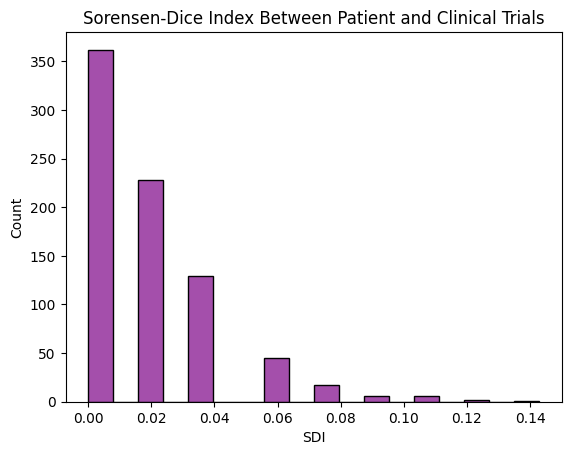

In [ ]:
# plot a histogram of the 'age' column using Seaborn
sns.histplot(data=final_df, x='SDI',color='#86148f').set_title('Sorensen-Dice Index Between Patient and Clinical Trials')
plt.show()

In [ ]:
pd.set_option("display.max_rows", 8)
final_df

,index,Rank,NCTId,BriefTitle,Condition,...,umls_id_ec,score_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
0,8,9,NCT05544916,A Study to Evaluate the Safety and Efficacy of...,Influenza|Respiratory Viral Infection,...,"[C0549206, C0006147, C0020517, C0013175, C0205...","[0.9999999403953552, 1.0, 0.9999998807907104, ...","[C0205319, C0439234, C0521346, C0427780, C0700...","[C0031809, C0439228, C0007637, C0150583, C0544...",0.091743
1,16,1,NCT04973462,Evaluation of The Efficacy of Triazavirin Vers...,Covid19,...,"[C0030705, C0008972, C1521895, C0023895, C0442...","[1.0, 1.0, 0.9999999403953552, 0.8328849673271...","[C0439234, C0040405, C0332554, C0927195, C0439...","[C0439228, C0439231, C1565489, C0311400, C0019...",0.000000
2,19,4,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,SARS-CoV-2 Infection,...,"[C0205434, C0012634, C0011849, C0020538, C0542...","[1.0, 0.8556983470916748, 1.0, 1.0, 1.0, 0.999...","[C0011900, C0019699, C1513302, C0032520, C0030...","[C0011900, C0021079, C0589120, C0205191, C0205...",0.019048
3,22,7,NCT05375799,Clinical and Electronic Record for Patients Wi...,COVID-19,...,"[C0025102, C0205257, C1511726, C1511726]","[1.0, 0.9999999403953552, 1.0, 1.0]","[C0011900, C0025102, C0035668, C0001675, C0022...","[C1511726, C0025102, C0205257]",0.019048
...,...,...,...,...,...,...,...,...,...,...,...
792,6286,975,NCT04910607,Social and Psychological Impacts of SARS-Cov-2...,Obesity|Covid19,...,"[C0030705, C0439234, C0001779]","[1.0, 1.0, 1.0]","[C0030705, C0439234, C0016094, C0271454]","[C0030705, C0439234, C0001779]",0.000000
793,6289,978,NCT04118543,"Oxfordshire Sedentariness, Obesity & Cardiomet...","Overweight/Obesity, Adolescent",...,"[C1301624, C1831738, C0015259, C0443288, C0027...","[1.0, 1.0, 1.0, 0.7905903458595276, 0.99999994...","[C1511481, C0679646, C0015259, C1879749, C0600...","[C0027765, C0015259, C0028580, C0443288, C1831...",0.037736
794,6307,996,NCT05120804,Family Functioning in Obesity Treatment for Me...,Obesity,...,"[C0034754, C0043266, C0376245, C0549206, C0270...","[1.0, 1.0, 1.0, 0.7196126580238342, 1.0, 0.999...","[C0025884, C0439234, C1826357, C0240339, C0578...","[C0031809, C0015259, C0270724, C0034754, C0043...",0.037736
795,6311,1000,NCT05467020,Association Between Peripheral Muscle Function...,Obesity,...,"[C0030706, C0080100, C0679823, C0008972, C0032...","[0.8831717371940613, 0.780156672000885, 0.8761...","[C0030705, C0243161]","[C1511481, C0030706, C0032961, C0679823, C0080...",0.000000


In [ ]:
pd.set_option("display.max_columns", 15)
pd.set_option("display.max_rows", 8)

recruiting_trials_df

,index,Rank,NCTId,BriefTitle,Condition,OverallStatus,EligibilityCriteria,...,score_ec,label_ec,umls_id_ec,text_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
0,29,30,NCT05771129,Feasibility Study of the Pulsed Electric Field...,Chronic Bronchitis,Recruiting,Inclusion Criteria:||Subject's age is ≥35 year...,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.740...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[C0681850, C0441994, C0035243, C0032285, C0026...","[Subject, lower, respiratory tract infection, ...","[C4055223, C0999593, C0162791, C1516084, C0006...","[C0034079, C0184252, C1457887, C0030705, C0184...",0.021053
1,33,34,NCT02315898,Inhaled Tissue Plasminogen Activator for Acute...,Plastic Bronchitis|Protein-Losing Enteropathie...,Recruiting,Inclusion Criteria (patients with plastic bron...,...,[],[],[],[],[],[],0.000000
2,50,51,NCT05646225,Early Mobilization With and Without Chest Phys...,Chronic Bronchitis,Recruiting,Inclusion Criteria:||Both gender of age 45-70 ...,...,"[1.0, 1.0, 1.0, 1.0, 0.7523831725120544]","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY]","[C0030705, C0012634, C0007226, C0011849, C0524...","[Patient, condition, cardiovascular, diabetes ...","[C0011900, C0001779, C0008677, C0079399]","[C0524851, C0011849, C0007226, C0030705, C0012...",0.021053
3,56,57,NCT03893370,RejuvenAir® System Trial for COPD With Chronic...,Chronic Bronchitis,Recruiting,Inclusion Criteria||Males and females ≥40 to ≤...,...,[],[],[],[],[],[],0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,4335,714,NCT04998851,A Study Evaluating B Cell Levels In Infants Of...,Multiple Sclerosis|Clinically Isolated Syndrome,Recruiting,Inclusion Criteria:||Woman is between 18 and 4...,...,[],[],[],[],"[C0006147, C0175636, C0011900, C0679006, C0439...",[],0.041667
409,4336,715,NCT04998812,A Study Evaluating B Cell Levels In Infants Po...,Multiple Sclerosis|Clinically Isolated Syndrome,Recruiting,Inclusion Criteria:||Diagnosis of MS or CIS (i...,...,"[1.0, 1.0, 1.0, 0.8901726007461548, 0.99999994...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[C0274281, C1882138, C0439231, C0043213, C0425...","[exposure, ocrelizumab, months, woman's, LMP, ...","[C1882138, C0274281, C0043210, C0032961, C0011...","[C0205318, C0013146, C0021081, C0032929, C0032...",0.000000
410,4349,728,NCT05380193,Serotype Distribution in Hospitalized Adult Wi...,Pneumonia|Pneumococcal Infections|Community-ac...,Recruiting,Inclusion Criteria:||Adults 18 years of age or...,...,"[1.0, 0.8925007581710815, 0.7336990237236023, ...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[C0242114, C0022424, C0027361, C0348011, C2347...","[Suspicion, judicial, protection|Individuals, ...","[C0184666, C0521530, C0242104, C0032227, C0009...","[C0027361, C0032285, C0348011, C0242114, C0701...",0.101010
411,4350,729,NCT02485847,IRIS Registry: Intelligent Research in Sight R...,Eye Diseases,Recruiting,Inclusion Criteria:||Patients who meet the den...,...,[],[],[],[],"[C0030705, C1514873, C0079809]",[],0.000000


In [ ]:
len(final_patient_df['Patient_Profile'][5])

57856

In [ ]:
patient_ner_df

,aspects,Patient_Profile,umls_codes_patient,score_pat,umls_id_pat,text_pat,label_pat,semantic_mapping_pat
0,allergies,Latex allergy Allergy to mould House dust mite...,"[{'text_pat': 'Latex allergy Allergy', 'umls_i...","[0.9578602910041809, 1.0, 1.0, 0.9999998807907...","[C0577628, C0339808, C0222058, C0740919, C0013...","[Latex allergy Allergy, House dust mite allerg...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTITY]","[Unknown, Disease, Unknown, Disease, Unknown, ..."
1,condition,Atopic dermatitis Otitis media Childhood asthm...,"[{'text_pat': 'Atopic dermatitis', 'umls_id_pa...","[1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, ...","[C0011615, C0029882, C0264408, C0018621, C0396...","[Atopic dermatitis, Otitis media, Childhood as...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Disease, Disease, Disease, Disease, Disease, ..."
2,devices,,[],[],[],[],[],[]
3,immunizations,Hep B adolescent or pediatric Hep B adolesce...,"[{'text_pat': 'Hep B', 'umls_id_pat': 'C016256...","[0.8482469916343689, 1.0, 0.8482469916343689, ...","[C0162569, C1521725, C0162569, C0694742, C0276...","[Hep B, pediatric, Hep B, pediatric Hib (PRP-O...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Disease, Unknown, Disease, Unknown, Disease, ..."
4,medications,Astemizole 10 MG Oral Tablet Amoxicillin 250 M...,"[{'text_pat': 'Astemizole', 'umls_id_pat': 'C0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.81247895...","[C0085170, C0024443, C1244600, C0024443, C0991...","[Astemizole, MG, Oral Tablet Amoxicillin, MG, ...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Unknown, Unknown, Clinical_Drug, Unknown, Unk..."
5,observations,Body Height Pain severity - 0-10 verbal numeri...,"[{'text_pat': 'Body Height Pain', 'umls_id_pat...","[0.8759792447090149, 1.0, 1.0, 1.0, 0.81690454...","[C0005890, C0449820, C0684224, C0005910, C0001...","[Body Height Pain, Score, Reported, Body Weigh...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
6,procedures,Medication Reconciliation (procedure) Medicati...,"[{'text_pat': 'Medication Reconciliation', 'um...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[C2317067, C1273434, C2317067, C0184661, C0420...","[Medication Reconciliation, Allergy screening ...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
7,birthday,1983-08-07,[],[],[],[],[],[]
8,marital,M,[],[],[],[],[],[]
9,race,white,"[{'text_pat': 'white', 'umls_id_pat': 'C000745...",[1.0],[C0007457],[white],[ENTITY],[Unknown]


In [ ]:
pd.set_option('display.max_colwidth', 150)
patient_profile = patient_ner_df[['aspects','Patient_Profile']]
patient_profile

,aspects,Patient_Profile
0,allergies,Latex allergy Allergy to mould House dust mite allergy Dander (animal) allergy Allergy to grass pollen Allergy to eggs Shellfish allergy
1,condition,Atopic dermatitis Otitis media Childhood asthma Seasonal allergic rhinitis Acute viral pharyngitis (disorder) Laceration of hand Streptococcal sor...
2,devices,
3,immunizations,Hep B adolescent or pediatric Hep B adolescent or pediatric Hib (PRP-OMP) IPV Hib (PRP-OMP) IPV IPV Influenza seasonal injectable preservativ...
4,medications,Astemizole 10 MG Oral Tablet Amoxicillin 250 MG Oral Capsule Acetaminophen 160 MG Chewable Tablet 120 ACTUAT Fluticasone propionate 0.044 MG/ACTUA...
5,observations,Body Height Pain severity - 0-10 verbal numeric rating [Score] - Reported Body Weight Weight-for-length Per age and sex Head Occipital-frontal cir...
6,procedures,Medication Reconciliation (procedure) Medication Reconciliation (procedure) Medication Reconciliation (procedure) Medication Reconciliation (proce...
7,birthday,1983-08-07
8,marital,M
9,race,white


In [ ]:
patient_ner_df.to_csv('parsed_patient_ehr.csv', index=False)
recruiting_trials_df.to_csv('recruiting_clinical_trials.csv', index=False)
final_df.to_csv('parsed_clinical_trials.csv', index=False)

In [ ]:
final_df['SDI'].max()

0.07881773399014778

In [ ]:
pd.set_option("display.min_rows", 6)
pd.set_option("display.max_rows", 6)
final_df

,index,Rank,NCTId,BriefTitle,Condition,OverallStatus,EligibilityCriteria,inclusion_criteria,exclusion_criteria,umls_codes_ic,...,score_ic,umls_codes_ec,label_ec,text_ec,umls_id_ec,semantic_mapping_ec,score_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
0,21,22,NCT03858231,Opioids Versus Non-Opioids Postoperative After...,"Knee Injuries|Pain, Postoperative|Opioid Use",Recruiting,Inclusion Criteria:||Subjects ≥ 18 years of ag...,Subjects ≥ 18 years of age through ≤ 80 years ...,Previously enrolled in this study (enrolled fo...,"[{'text_ic': 'Subjects', 'umls_id_ic': 'C00801...",...,"[0.845239520072937, 1.0, 1.0, 1.0, 0.780005753...","[{'text_ec': 'study', 'umls_id_ec': 'C0008972'...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[study, contralateral, knee, patients, knee li...","[C0008972, C0441988, C0022742, C0030705, C0206...","[Unknown, Unknown, Body_Part, Unknown, Body_Pa...","[1.0, 1.0, 1.0, 1.0, 0.8956663608551025, 0.706...","[C0728938, C0001779, C0206058, C0187769, C0408...","[C0030920, C0683368, C1514873, C0019080, C0221...",0.010204
1,51,52,NCT04976387,Post Operative Analgesia and Patient Satisfaction,Postoperative Pain|Patient Satisfaction|Analgesia,Recruiting,Inclusion Criteria:||Patients between the ages...,Patients between the ages of 18 and 89 years o...,Patients under 18 years old or older than 89 y...,"[{'text_ic': 'Patients', 'umls_id_ic': 'C00307...",...,"[1.0, 1.0, 1.0, 1.0]","[{'text_ec': 'Patients', 'umls_id_ec': 'C00307...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Patients, older, years, Acetaminophen, NSAIDS...","[C0030705, C0001795, C0439234, C0000970, C0003...","[Unknown, Age_Group, Unknown, Unknown, Drug, U...","[1.0, 0.7188849449157715, 1.0, 1.0, 0.74860709...","[C0162574, C0030705, C0001779, C0439234]","[C0549206, C0001795, C0030705, C0000970, C3266...",0.020305
2,78,79,NCT03749616,Effect of NSAID Use on Pain and Opioid Consump...,Distal Radius Fracture,Recruiting,Inclusion Criteria:||Age ≥ 18|Distal radius fr...,Age ≥ 18|Distal radius fracture,Contraindication to NSAID use (cannot tolerate...,"[{'text_ic': 'Age', 'umls_id_ic': 'C0001779', ...",...,"[1.0, 0.832638144493103]","[{'text_ec': 'Contraindication', 'umls_id_ec':...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Contraindication, NSAID, gastritis, ulcers, c...","[C0522473, C0003211, C0017152, C0041582, C2316...","[Unknown, Drug, Disease, Unknown, Disease, Unk...","[1.0, 1.0, 1.0, 1.0, 0.9837002158164978, 1.0, ...","[C0001779, C0034628]","[C0019080, C0549206, C2316401, C0522473, C0270...",0.010204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,10513,94,NCT04874714,Efficacy and Safety Evaluation for the Treatme...,Allergic Rhinoconjunctivitis|Perennial Allergi...,Recruiting,Inclusion Criteria:||Subjects who have signed ...,Subjects who have signed the informed consent|...,Subjects who have received prior immunotherapy...,"[{'text_ic': 'Subjects', 'umls_id_ic': 'C00801...",...,"[0.845239520072937, 1.0, 0.7454175353050232, 1...","[{'text_ec': 'Subjects', 'umls_id_ec': 'C00801...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Subjects, immunotherapy, treatment, years, im...","[C0080105, C0005525, C0039798, C0439234, C0005...","[Unknown, Drug, Unknown, Unknown, Drug, Unknow...","[0.845239520072937, 1.0, 1.0, 1.0, 1.0, 1.0, 1...","[C0331509, C0008902, C0449432, C3829562, C0018...","[C0043210, C0205082, C3245505, C0005525, C0001...",0.020305
1367,10538,119,NCT04891237,Efficacy and Safety Evaluation for the Treatme...,"Rhinitis, Allergic|Rhinoconjunctivitis|Asthma,...",Recruiting,Inclusion Criteria:||Subject who has signed th...,Subject who has signed the informed consent.|S...,Subjects polysensitized to other aeroallergens...,"[{'text_ic': 'Subject', 'umls_id_ic': 'C068185...",...,"[1.0, 1.0, 0.9999998807907104, 0.9999999403953...","[{'text_ec': 'Subjects', 'umls_id_ec': 'C00801...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Subjects, aeroallergens, epithelia, occ

In [ ]:
patient_ner_df,recruiting_trials_df,final_df = cts_parser(patients_df,model)
final_df

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data
Step 3/9 : Creating list of patient conditions 
Found  32  unique conditions on patient EHR
Step 4/9 : Querying for clinical trials
Acetaminophen+325+MG
https://clinicaltrials.gov/api/query/study_fields?expr=Acetaminophen+325+MG&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Acute+bronchitis
https://clinicaltrials.gov/api/query/study_fields?expr=Acute+bronchitis&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Acute+viral+pharyngitis
https://clinicaltrials.gov/api/query/study_fields?expr=Acute+viral+pharyngitis&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Anemia
https://clinicaltrials.gov/api/query/study_fields?expr=Anemia&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Atopi

,index,Rank,NCTId,BriefTitle,Condition,OverallStatus,EligibilityCriteria,inclusion_criteria,exclusion_criteria,umls_codes_ic,...,score_ic,umls_codes_ec,label_ec,text_ec,umls_id_ec,semantic_mapping_ec,score_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
0,21,22,NCT03858231,Opioids Versus Non-Opioids Postoperative After...,"Knee Injuries|Pain, Postoperative|Opioid Use",Recruiting,Inclusion Criteria:||Subjects ≥ 18 years of ag...,Subjects ≥ 18 years of age through ≤ 80 years ...,Previously enrolled in this study (enrolled fo...,"[{'text_ic': 'Subjects', 'umls_id_ic': 'C00801...",...,"[0.845239520072937, 1.0, 1.0, 1.0, 0.780005753...","[{'text_ec': 'study', 'umls_id_ec': 'C0008972'...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[study, contralateral, knee, patients, knee li...","[C0008972, C0441988, C0022742, C0030705, C0206...","[Unknown, Unknown, Body_Part, Unknown, Body_Pa...","[1.0, 1.0, 1.0, 1.0, 0.8956663608551025, 0.706...","[C0728938, C0001779, C0206058, C0187769, C0408...","[C0030920, C0683368, C1514873, C0019080, C0221...",0.010204
1,51,52,NCT04976387,Post Operative Analgesia and Patient Satisfaction,Postoperative Pain|Patient Satisfaction|Analgesia,Recruiting,Inclusion Criteria:||Patients between the ages...,Patients between the ages of 18 and 89 years o...,Patients under 18 years old or older than 89 y...,"[{'text_ic': 'Patients', 'umls_id_ic': 'C00307...",...,"[1.0, 1.0, 1.0, 1.0]","[{'text_ec': 'Patients', 'umls_id_ec': 'C00307...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Patients, older, years, Acetaminophen, NSAIDS...","[C0030705, C0001795, C0439234, C0000970, C0003...","[Unknown, Age_Group, Unknown, Unknown, Drug, U...","[1.0, 0.7188849449157715, 1.0, 1.0, 0.74860709...","[C0162574, C0030705, C0001779, C0439234]","[C0549206, C0001795, C0030705, C0000970, C3266...",0.020305
2,78,79,NCT03749616,Effect of NSAID Use on Pain and Opioid Consump...,Distal Radius Fracture,Recruiting,Inclusion Criteria:||Age ≥ 18|Distal radius fr...,Age ≥ 18|Distal radius fracture,Contraindication to NSAID use (cannot tolerate...,"[{'text_ic': 'Age', 'umls_id_ic': 'C0001779', ...",...,"[1.0, 0.832638144493103]","[{'text_ec': 'Contraindication', 'umls_id_ec':...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Contraindication, NSAID, gastritis, ulcers, c...","[C0522473, C0003211, C0017152, C0041582, C2316...","[Unknown, Drug, Disease, Unknown, Disease, Unk...","[1.0, 1.0, 1.0, 1.0, 0.9837002158164978, 1.0, ...","[C0001779, C0034628]","[C0019080, C0549206, C2316401, C0522473, C0270...",0.010204
3,82,83,NCT03823534,Post-Op Pain Control for Prophylactic Intramed...,Bone Metastases|Lymphoma|Multiple Myeloma|Opio...,Recruiting,Inclusion Criteria:||Femoral Shaft or Neck bon...,Femoral Shaft or Neck bone lesion|18 years old...,Concurrent pathologic fracture|History of adva...,"[{'text_ic': 'Femoral Shaft', 'umls_id_ic': 'C...",...,"[1.0, 0.809645414352417, 0.7952589392662048, 1.0]","[{'text_ec': 'Concurrent', 'umls_id_ec': 'C020...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Concurrent, pathologic, advanced renal, impai...","[C0205420, C1521733, C0205179, C0221099, C0030...","[Unknown, Unknown, Unknown, Unknown, Disease, ...","[1.0, 1.0, 0.8717132806777954, 0.8045898675918...","[C0027530, C0588193, C0015811, C1704243]","[C0030920, C0005779, C0221099, C0013146, C0018...",0.000000
4,83,84,NCT04990804,Opioid Free vs. Standard Perioperative Pain Re...,Opioid Use|Spinal Diseases|Surgery--Complicati...,Recruiting,Inclusion Criteria:||Radiographic evidence of ...,Radiographic evidence of degenerative cervical...,Preoperative chronic opioid use as determined ...,"[{'text_ic': 'Radiographic', 'umls_id_ic': 'C0...",...,"[1.0, 1.0, 1.0, 1.0, 0.7952378392219543]","[{'text_ec': 'Preoperative', 'umls_id_ec': 'C0...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Preoperative, self report, cervical fusion|Do...","[C0445204, C0681906, C0186010, C0030705, C0231...","[Unknown, Unknown, Unknown, Unknown, Unknown, ...","[1.0,

In [ ]:
#Make lists of conditions and their semantic counterparts from the parsed patient dataframe
list2 = patient_ner_df['semantic_mapping_pat'].explode().tolist
list1 = patient_ner_df['text_pat'].explode().tolist

In [ ]:
text = '''ACTUAT
https://clinicaltrials.gov/api/query/study_fields?expr=ACTUAT&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Ab
https://clinicaltrials.gov/api/query/study_fields?expr=Ab&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Acetaminophen
https://clinicaltrials.gov/api/query/study_fields?expr=Acetaminophen&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Acetaminophen+325+MG
https://clinicaltrials.gov/api/query/study_fields?expr=Acetaminophen+325+MG&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Acute+bronchitis
https://clinicaltrials.gov/api/query/study_fields?expr=Acute+bronchitis&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Acute+viral+pharyngitis
https://clinicaltrials.gov/api/query/study_fields?expr=Acute+viral+pharyngitis&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Adenovirus
https://clinicaltrials.gov/api/query/study_fields?expr=Adenovirus&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Admission
https://clinicaltrials.gov/api/query/study_fields?expr=Admission&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Alanine+aminotransferase
https://clinicaltrials.gov/api/query/study_fields?expr=Alanine+aminotransferase&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Alkaline+phosphatase
https://clinicaltrials.gov/api/query/study_fields?expr=Alkaline+phosphatase&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Allergy+screening+test
https://clinicaltrials.gov/api/query/study_fields?expr=Allergy+screening+test&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Anemia
https://clinicaltrials.gov/api/query/study_fields?expr=Anemia&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Arterial+blood+Diastolic+Blood+Pressure
https://clinicaltrials.gov/api/query/study_fields?expr=Arterial+blood+Diastolic+Blood+Pressure&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Aspartate+aminotransferase
https://clinicaltrials.gov/api/query/study_fields?expr=Aspartate+aminotransferase&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Astemizole
https://clinicaltrials.gov/api/query/study_fields?expr=Astemizole&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Asthma+screening
https://clinicaltrials.gov/api/query/study_fields?expr=Asthma+screening&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Atopic+dermatitis
https://clinicaltrials.gov/api/query/study_fields?expr=Atopic+dermatitis&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Auto
https://clinicaltrials.gov/api/query/study_fields?expr=Auto&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated
https://clinicaltrials.gov/api/query/study_fields?expr=Automated&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Basophils
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Basophils&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Eosinophils
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Eosinophils&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Erythrocytes
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Erythrocytes&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Glucose
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Glucose&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Hemoglobin
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Hemoglobin&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Lymphocytes
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Lymphocytes&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+MCH
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+MCH&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+MCHC
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+MCHC&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+MCV
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+MCV&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Monocytes
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Monocytes&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Neutrophils
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Neutrophils&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Platelet+distribution+width
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Platelet+distribution+width&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Platelet+mean+volume
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Platelet+mean+volume&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Platelets
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Platelets&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+RDW
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+RDW&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Automated+count+Tobacco+smoking+status
https://clinicaltrials.gov/api/query/study_fields?expr=Automated+count+Tobacco+smoking+status&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
BMI
https://clinicaltrials.gov/api/query/study_fields?expr=BMI&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Blood
https://clinicaltrials.gov/api/query/study_fields?expr=Blood&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Blood+Body+temperature
https://clinicaltrials.gov/api/query/study_fields?expr=Blood+Body+temperature&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Blood+Hematocrit
https://clinicaltrials.gov/api/query/study_fields?expr=Blood+Hematocrit&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Blood+Hemoglobin
https://clinicaltrials.gov/api/query/study_fields?expr=Blood+Hemoglobin&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Blood+Pain
https://clinicaltrials.gov/api/query/study_fields?expr=Blood+Pain&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Blood+Pressure
https://clinicaltrials.gov/api/query/study_fields?expr=Blood+Pressure&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Blood+WBC
https://clinicaltrials.gov/api/query/study_fields?expr=Blood+WBC&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Body+Height
https://clinicaltrials.gov/api/query/study_fields?expr=Body+Height&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Body+Height+Pain
https://clinicaltrials.gov/api/query/study_fields?expr=Body+Height+Pain&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Body+Mass+Index
https://clinicaltrials.gov/api/query/study_fields?expr=Body+Mass+Index&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Body+Weight
https://clinicaltrials.gov/api/query/study_fields?expr=Body+Weight&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Body+Weight+Body+Mass+Index
https://clinicaltrials.gov/api/query/study_fields?expr=Body+Weight+Body+Mass+Index&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Body+mass+index
https://clinicaltrials.gov/api/query/study_fields?expr=Body+mass+index&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Body+temperature
https://clinicaltrials.gov/api/query/study_fields?expr=Body+temperature&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Brief+general+examination
https://clinicaltrials.gov/api/query/study_fields?expr=Brief+general+examination&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
COVID-19
https://clinicaltrials.gov/api/query/study_fields?expr=COVID-19&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Carbon+Dioxide
https://clinicaltrials.gov/api/query/study_fields?expr=Carbon+Dioxide&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Carbon+dioxide
https://clinicaltrials.gov/api/query/study_fields?expr=Carbon+dioxide&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Cat+dander
https://clinicaltrials.gov/api/query/study_fields?expr=Cat+dander&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Cefuroxime
https://clinicaltrials.gov/api/query/study_fields?expr=Cefuroxime&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Childhood+asthma
https://clinicaltrials.gov/api/query/study_fields?expr=Childhood+asthma&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Chronic+intractable+migraine
https://clinicaltrials.gov/api/query/study_fields?expr=Chronic+intractable+migraine&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Chronic+pain
https://clinicaltrials.gov/api/query/study_fields?expr=Chronic+pain&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Cladosporium+herbarum
https://clinicaltrials.gov/api/query/study_fields?expr=Cladosporium+herbarum&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Coagulation+assay
https://clinicaltrials.gov/api/query/study_fields?expr=Coagulation+assay&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Cow+milk
https://clinicaltrials.gov/api/query/study_fields?expr=Cow+milk&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Dander
https://clinicaltrials.gov/api/query/study_fields?expr=Dander&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Diarrhea+symptom
https://clinicaltrials.gov/api/query/study_fields?expr=Diarrhea+symptom&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Diastolic+Blood+Pressure
https://clinicaltrials.gov/api/query/study_fields?expr=Diastolic+Blood+Pressure&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Drug+overdose
https://clinicaltrials.gov/api/query/study_fields?expr=Drug+overdose&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Egg+white+IgE
https://clinicaltrials.gov/api/query/study_fields?expr=Egg+white+IgE&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Enoxaparin+sodium+100+MG/ML
https://clinicaltrials.gov/api/query/study_fields?expr=Enoxaparin+sodium+100+MG/ML&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Entitic+mass
https://clinicaltrials.gov/api/query/study_fields?expr=Entitic+mass&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Entitic+volume
https://clinicaltrials.gov/api/query/study_fields?expr=Entitic+volume&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Erythrocyte
https://clinicaltrials.gov/api/query/study_fields?expr=Erythrocyte&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Extended+Release
https://clinicaltrials.gov/api/query/study_fields?expr=Extended+Release&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Extraction
https://clinicaltrials.gov/api/query/study_fields?expr=Extraction&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
FEU
https://clinicaltrials.gov/api/query/study_fields?expr=FEU&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Fatigue
https://clinicaltrials.gov/api/query/study_fields?expr=Fatigue&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Fever
https://clinicaltrials.gov/api/query/study_fields?expr=Fever&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Fluticasone+propionate
https://clinicaltrials.gov/api/query/study_fields?expr=Fluticasone+propionate&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Glucose+Urea
https://clinicaltrials.gov/api/query/study_fields?expr=Glucose+Urea&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
HR
https://clinicaltrials.gov/api/query/study_fields?expr=HR&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
HYDROcodone+Bitartrate+5+MG
https://clinicaltrials.gov/api/query/study_fields?expr=HYDROcodone+Bitartrate+5+MG&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Heart+rate
https://clinicaltrials.gov/api/query/study_fields?expr=Heart+rate&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Hemoglobin+A1c/Hemoglobin.total
https://clinicaltrials.gov/api/query/study_fields?expr=Hemoglobin+A1c/Hemoglobin.total&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Hep+B
https://clinicaltrials.gov/api/query/study_fields?expr=Hep+B&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Honey+bee
https://clinicaltrials.gov/api/query/study_fields?expr=Honey+bee&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
House+dust+mite+allergy
https://clinicaltrials.gov/api/query/study_fields?expr=House+dust+mite+allergy&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Human+metapneumovirus+RNA
https://clinicaltrials.gov/api/query/study_fields?expr=Human+metapneumovirus+RNA&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
INR
https://clinicaltrials.gov/api/query/study_fields?expr=INR&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
IPV
https://clinicaltrials.gov/api/query/study_fields?expr=IPV&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
IgE
https://clinicaltrials.gov/api/query/study_fields?expr=IgE&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
IgE+Ab
https://clinicaltrials.gov/api/query/study_fields?expr=IgE+Ab&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Impacted+molars
https://clinicaltrials.gov/api/query/study_fields?expr=Impacted+molars&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Influenza+virus+B+RNA
https://clinicaltrials.gov/api/query/study_fields?expr=Influenza+virus+B+RNA&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Inhaler
https://clinicaltrials.gov/api/query/study_fields?expr=Inhaler&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Laceration
https://clinicaltrials.gov/api/query/study_fields?expr=Laceration&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Lactate
https://clinicaltrials.gov/api/query/study_fields?expr=Lactate&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Lactate+dehydrogenase
https://clinicaltrials.gov/api/query/study_fields?expr=Lactate+dehydrogenase&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Latex+allergy+Allergy
https://clinicaltrials.gov/api/query/study_fields?expr=Latex+allergy+Allergy&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Leukocytes
https://clinicaltrials.gov/api/query/study_fields?expr=Leukocytes&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Loss+of+taste
https://clinicaltrials.gov/api/query/study_fields?expr=Loss+of+taste&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Low+Density+Lipoprotein+Cholesterol
https://clinicaltrials.gov/api/query/study_fields?expr=Low+Density+Lipoprotein+Cholesterol&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
MCV
https://clinicaltrials.gov/api/query/study_fields?expr=MCV&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
MG
https://clinicaltrials.gov/api/query/study_fields?expr=MG&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
MG/ML
https://clinicaltrials.gov/api/query/study_fields?expr=MG/ML&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
ML
https://clinicaltrials.gov/api/query/study_fields?expr=ML&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Mass/volume
https://clinicaltrials.gov/api/query/study_fields?expr=Mass/volume&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Medication+Reconciliation
https://clinicaltrials.gov/api/query/study_fields?expr=Medication+Reconciliation&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Metered+Dose
https://clinicaltrials.gov/api/query/study_fields?expr=Metered+Dose&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
NAA
https://clinicaltrials.gov/api/query/study_fields?expr=NAA&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Nitrogen+Creatinine
https://clinicaltrials.gov/api/query/study_fields?expr=Nitrogen+Creatinine&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Occipital-frontal+circumference
https://clinicaltrials.gov/api/query/study_fields?expr=Occipital-frontal+circumference&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Oral+Capsule
https://clinicaltrials.gov/api/query/study_fields?expr=Oral+Capsule&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Oral+Tablet
https://clinicaltrials.gov/api/query/study_fields?expr=Oral+Tablet&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Oral+Tablet+Abuse-Deterrent
https://clinicaltrials.gov/api/query/study_fields?expr=Oral+Tablet+Abuse-Deterrent&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Oral+Tablet+Amoxicillin
https://clinicaltrials.gov/api/query/study_fields?expr=Oral+Tablet+Amoxicillin&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Oral+Tablet+Penicillin+V
https://clinicaltrials.gov/api/query/study_fields?expr=Oral+Tablet+Penicillin+V&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Otitis+media
https://clinicaltrials.gov/api/query/study_fields?expr=Otitis+media&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Oxycodone+Hydrochloride+15+MG
https://clinicaltrials.gov/api/query/study_fields?expr=Oxycodone+Hydrochloride+15+MG&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Oxycodone+Hydrochloride+5+MG
https://clinicaltrials.gov/api/query/study_fields?expr=Oxycodone+Hydrochloride+5+MG&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Oxygen+administration
https://clinicaltrials.gov/api/query/study_fields?expr=Oxygen+administration&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Oxygen+saturation
https://clinicaltrials.gov/api/query/study_fields?expr=Oxygen+saturation&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
PHQ-9
https://clinicaltrials.gov/api/query/study_fields?expr=PHQ-9&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
PHQ-9+Medication+Reconciliation
https://clinicaltrials.gov/api/query/study_fields?expr=PHQ-9+Medication+Reconciliation&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
PT
https://clinicaltrials.gov/api/query/study_fields?expr=PT&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Pain+severity
https://clinicaltrials.gov/api/query/study_fields?expr=Pain+severity&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Parainfluenza+virus+1+RNA
https://clinicaltrials.gov/api/query/study_fields?expr=Parainfluenza+virus+1+RNA&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Parainfluenza+virus+2+RNA
https://clinicaltrials.gov/api/query/study_fields?expr=Parainfluenza+virus+2+RNA&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Parainfluenza+virus+3+RNA
https://clinicaltrials.gov/api/query/study_fields?expr=Parainfluenza+virus+3+RNA&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Peanut
https://clinicaltrials.gov/api/query/study_fields?expr=Peanut&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Per+age
https://clinicaltrials.gov/api/query/study_fields?expr=Per+age&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Peripheral+blood+smear
https://clinicaltrials.gov/api/query/study_fields?expr=Peripheral+blood+smear&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Plain+chest+X-ray+procedure
https://clinicaltrials.gov/api/query/study_fields?expr=Plain+chest+X-ray+procedure&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Plasma
https://clinicaltrials.gov/api/query/study_fields?expr=Plasma&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Plasma+Albumin
https://clinicaltrials.gov/api/query/study_fields?expr=Plasma+Albumin&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Plasma+C+reactive+protein
https://clinicaltrials.gov/api/query/study_fields?expr=Plasma+C+reactive+protein&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Plasma+Calcium
https://clinicaltrials.gov/api/query/study_fields?expr=Plasma+Calcium&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Plasma+Chloride
https://clinicaltrials.gov/api/query/study_fields?expr=Plasma+Chloride&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Plasma+Creatinine
https://clinicaltrials.gov/api/query/study_fields?expr=Plasma+Creatinine&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Plasma+Potassium
https://clinicaltrials.gov/api/query/study_fields?expr=Plasma+Potassium&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Plasma+Sodium
https://clinicaltrials.gov/api/query/study_fields?expr=Plasma+Sodium&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Platelet+poor+plasma
https://clinicaltrials.gov/api/query/study_fields?expr=Platelet+poor+plasma&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Platelet+poor+plasma+Ferritin
https://clinicaltrials.gov/api/query/study_fields?expr=Platelet+poor+plasma+Ferritin&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Pneumonia
https://clinicaltrials.gov/api/query/study_fields?expr=Pneumonia&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Presence
https://clinicaltrials.gov/api/query/study_fields?expr=Presence&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Procalcitonin
https://clinicaltrials.gov/api/query/study_fields?expr=Procalcitonin&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Prothrombin+time
https://clinicaltrials.gov/api/query/study_fields?expr=Prothrombin+time&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
RBC
https://clinicaltrials.gov/api/query/study_fields?expr=RBC&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Ratio
https://clinicaltrials.gov/api/query/study_fields?expr=Ratio&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Reported
https://clinicaltrials.gov/api/query/study_fields?expr=Reported&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Respiratory+distress
https://clinicaltrials.gov/api/query/study_fields?expr=Respiratory+distress&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Respiratory+rate
https://clinicaltrials.gov/api/query/study_fields?expr=Respiratory+rate&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Respiratory+specimen
https://clinicaltrials.gov/api/query/study_fields?expr=Respiratory+specimen&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Respiratory+syncytial+virus+RNA
https://clinicaltrials.gov/api/query/study_fields?expr=Respiratory+syncytial+virus+RNA&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Review+of+systems
https://clinicaltrials.gov/api/query/study_fields?expr=Review+of+systems&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Rhinovirus+RNA
https://clinicaltrials.gov/api/query/study_fields?expr=Rhinovirus+RNA&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Score
https://clinicaltrials.gov/api/query/study_fields?expr=Score&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Seasonal+allergic+rhinitis
https://clinicaltrials.gov/api/query/study_fields?expr=Seasonal+allergic+rhinitis&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Serum
https://clinicaltrials.gov/api/query/study_fields?expr=Serum&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Serum+American+house+dust+mite
https://clinicaltrials.gov/api/query/study_fields?expr=Serum+American+house+dust+mite&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Serum+Body+Height+Pain
https://clinicaltrials.gov/api/query/study_fields?expr=Serum+Body+Height+Pain&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Serum+Latex
https://clinicaltrials.gov/api/query/study_fields?expr=Serum+Latex&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Serum+Pain+severity
https://clinicaltrials.gov/api/query/study_fields?expr=Serum+Pain+severity&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Serum+Walnut+IgE+Ab
https://clinicaltrials.gov/api/query/study_fields?expr=Serum+Walnut+IgE+Ab&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Shellfish+allergy
https://clinicaltrials.gov/api/query/study_fields?expr=Shellfish+allergy&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Social+history
https://clinicaltrials.gov/api/query/study_fields?expr=Social+history&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Sodium+Potassium+Chloride
https://clinicaltrials.gov/api/query/study_fields?expr=Sodium+Potassium+Chloride&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Sodium+Potassium+Chloride+Carbon+Dioxide
https://clinicaltrials.gov/api/query/study_fields?expr=Sodium+Potassium+Chloride+Carbon+Dioxide&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Solano+County
https://clinicaltrials.gov/api/query/study_fields?expr=Solano+County&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Sore+throat+symptom
https://clinicaltrials.gov/api/query/study_fields?expr=Sore+throat+symptom&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Sputum+finding
https://clinicaltrials.gov/api/query/study_fields?expr=Sputum+finding&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Streptococcal+sore+throat
https://clinicaltrials.gov/api/query/study_fields?expr=Streptococcal+sore+throat&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Subcutaneous+immunotherapy
https://clinicaltrials.gov/api/query/study_fields?expr=Subcutaneous+immunotherapy&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Subcutaneous+immunotherapy+Extraction
https://clinicaltrials.gov/api/query/study_fields?expr=Subcutaneous+immunotherapy+Extraction&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Suspected
https://clinicaltrials.gov/api/query/study_fields?expr=Suspected&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Suture
https://clinicaltrials.gov/api/query/study_fields?expr=Suture&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Syringe
https://clinicaltrials.gov/api/query/study_fields?expr=Syringe&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Tablet
https://clinicaltrials.gov/api/query/study_fields?expr=Tablet&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Throat+culture
https://clinicaltrials.gov/api/query/study_fields?expr=Throat+culture&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Tobacco+smoking
https://clinicaltrials.gov/api/query/study_fields?expr=Tobacco+smoking&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Tobacco+smoking+status
https://clinicaltrials.gov/api/query/study_fields?expr=Tobacco+smoking+status&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Total+Cholesterol
https://clinicaltrials.gov/api/query/study_fields?expr=Total+Cholesterol&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Viral+sinusitis
https://clinicaltrials.gov/api/query/study_fields?expr=Viral+sinusitis&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
Volume+Fraction
https://clinicaltrials.gov/api/query/study_fields?expr=Volume+Fraction&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
adult
https://clinicaltrials.gov/api/query/study_fields?expr=adult&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
age
https://clinicaltrials.gov/api/query/study_fields?expr=age&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
aura
https://clinicaltrials.gov/api/query/study_fields?expr=aura&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
burn+unit
https://clinicaltrials.gov/api/query/study_fields?expr=burn+unit&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
detection
https://clinicaltrials.gov/api/query/study_fields?expr=detection&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
disorder
https://clinicaltrials.gov/api/query/study_fields?expr=disorder&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
distribution
https://clinicaltrials.gov/api/query/study_fields?expr=distribution&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
eggs
https://clinicaltrials.gov/api/query/study_fields?expr=eggs&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
ferrous+sulfate+325+MG
https://clinicaltrials.gov/api/query/study_fields?expr=ferrous+sulfate+325+MG&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
finding
https://clinicaltrials.gov/api/query/study_fields?expr=finding&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
forearm
https://clinicaltrials.gov/api/query/study_fields?expr=forearm&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
gender
https://clinicaltrials.gov/api/query/study_fields?expr=gender&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
grass+pollen+Allergy
https://clinicaltrials.gov/api/query/study_fields?expr=grass+pollen+Allergy&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
leukocytes
https://clinicaltrials.gov/api/query/study_fields?expr=leukocytes&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
long+stay+hospital
https://clinicaltrials.gov/api/query/study_fields?expr=long+stay+hospital&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
loss
https://clinicaltrials.gov/api/query/study_fields?expr=loss&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
mask
https://clinicaltrials.gov/api/query/study_fields?expr=mask&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
meningococcal+MCV4P
https://clinicaltrials.gov/api/query/study_fields?expr=meningococcal+MCV4P&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
narrative
https://clinicaltrials.gov/api/query/study_fields?expr=narrative&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
negative
https://clinicaltrials.gov/api/query/study_fields?expr=negative&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
pediatric
https://clinicaltrials.gov/api/query/study_fields?expr=pediatric&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
pediatric+Hib+PRP-OMP+IPV+Hib
https://clinicaltrials.gov/api/query/study_fields?expr=pediatric+Hib+PRP-OMP+IPV+Hib&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
physical+object
https://clinicaltrials.gov/api/query/study_fields?expr=physical+object&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
positive
https://clinicaltrials.gov/api/query/study_fields?expr=positive&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
positive+screening
https://clinicaltrials.gov/api/query/study_fields?expr=positive+screening&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
preservative
https://clinicaltrials.gov/api/query/study_fields?expr=preservative&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
probe
https://clinicaltrials.gov/api/query/study_fields?expr=probe&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
probe+detection
https://clinicaltrials.gov/api/query/study_fields?expr=probe+detection&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
procedure
https://clinicaltrials.gov/api/query/study_fields?expr=procedure&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
prone+position
https://clinicaltrials.gov/api/query/study_fields?expr=prone+position&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
pyruvate+reaction+Creatine+kinase
https://clinicaltrials.gov/api/query/study_fields?expr=pyruvate+reaction+Creatine+kinase&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
screening
https://clinicaltrials.gov/api/query/study_fields?expr=screening&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
severity
https://clinicaltrials.gov/api/query/study_fields?expr=severity&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
sex+Head
https://clinicaltrials.gov/api/query/study_fields?expr=sex+Head&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
white
https://clinicaltrials.gov/api/query/study_fields?expr=white&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
width
https://clinicaltrials.gov/api/query/study_fields?expr=width&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
wisdom+tooth+Medication+Reconciliation
https://clinicaltrials.gov/api/query/study_fields?expr=wisdom+tooth+Medication+Reconciliation&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv
wisdom+tooth+negative+screening
https://clinicaltrials.gov/api/query/study_fields?expr=wisdom+tooth+negative+screening&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria&min_rnk=1&max_rnk=1000&fmt=csv'''

In [ ]:
# Define a regular expression pattern to match non-url text
pattern = r"(?<!\S)(?!https?://)\S+"

# Find all matches of the pattern in the text and store them in a list
nonurl_list = re.findall(pattern, text)

# Print the list of non-url elements
print(nonurl_list)

['ACTUAT', 'Ab', 'Acetaminophen', 'Acetaminophen+325+MG', 'Acute+bronchitis', 'Acute+viral+pharyngitis', 'Adenovirus', 'Admission', 'Alanine+aminotransferase', 'Alkaline+phosphatase', 'Allergy+screening+test', 'Anemia', 'Arterial+blood+Diastolic+Blood+Pressure', 'Aspartate+aminotransferase', 'Astemizole', 'Asthma+screening', 'Atopic+dermatitis', 'Auto', 'Automated', 'Automated+count', 'Automated+count+Basophils', 'Automated+count+Eosinophils', 'Automated+count+Erythrocytes', 'Automated+count+Glucose', 'Automated+count+Hemoglobin', 'Automated+count+Lymphocytes', 'Automated+count+MCH', 'Automated+count+MCHC', 'Automated+count+MCV', 'Automated+count+Monocytes', 'Automated+count+Neutrophils', 'Automated+count+Platelet+distribution+width', 'Automated+count+Platelet+mean+volume', 'Automated+count+Platelets', 'Automated+count+RDW', 'Automated+count+Tobacco+smoking+status', 'BMI', 'Blood', 'Blood+Body+temperature', 'Blood+Hematocrit', 'Blood+Hemoglobin', 'Blood+Pain', 'Blood+Pressure', 'Blood+

In [ ]:
len(nonurl_list)

221